In [1]:
R.home()

[1] "/home/chensijie/software/anaconda3/envs/r40py38/lib/R"

In [10]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(SeuratDisk)
    library(ggpubr)
    library(tictoc)
    library(future)
    library(ComplexHeatmap)
    library(circlize)
    library("Nebulosa")
})

o <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [3]:
load("t.cd4.rda")
ls()

[1] "o"     "t.cd4"

In [4]:
# 1.1 收集表达矩阵
mat  = GetAssayData(t.cd4, slot = "data", assay = "RNA")

# 1.2 把细胞按某种想要的顺序排好
ordered.cells <- rownames(t.cd4@meta.data)

# 1.3 选择一列感兴趣的基因用于绘图
features.sel <-  unique(c("PTPRC","PECAM1","COL1A1","EPCAM", "ITGAX","ITGAM",
                          "TRAC","TRBC1",'TRBC2', "TRDC","TRGC1","TRGC2",
                          "CD79A","MS4A1","CD3D","CD3E","CD4","CD8A","CD8B","TBX21","TRAC","TRBC1",'TRBC2',
                          "TRDC","TRGC1","TRGC2",
                          "NCAM1","FCGR3A",
                          "GATA3","RORC","FOXP3","CTLA4","TCF7","LEF1",
           "IL2RA",'CD44','CD69',"SELL",'IL7R',"CD27","CD28","CCR7","KIT",
           "ITGAE","NKG7","IFNG","PRF1",'GZMA','GZMB',"GZMK","IL17A","IL23R",
            "CD40LG","TOX2","ICOS","PDCD1",
            "ISG15","IFIT1","IFIT2","IFIT3", "CXCR6","CCR6",
            'TNF', 'IL4'))

# 1.4 重新组织原始矩阵按行列
mat = as.matrix( mat[features.sel, ordered.cells] )


sub_grp
  1   2   3   4   5   6   7   8 
 62 195 136  57  40  65  48  39 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



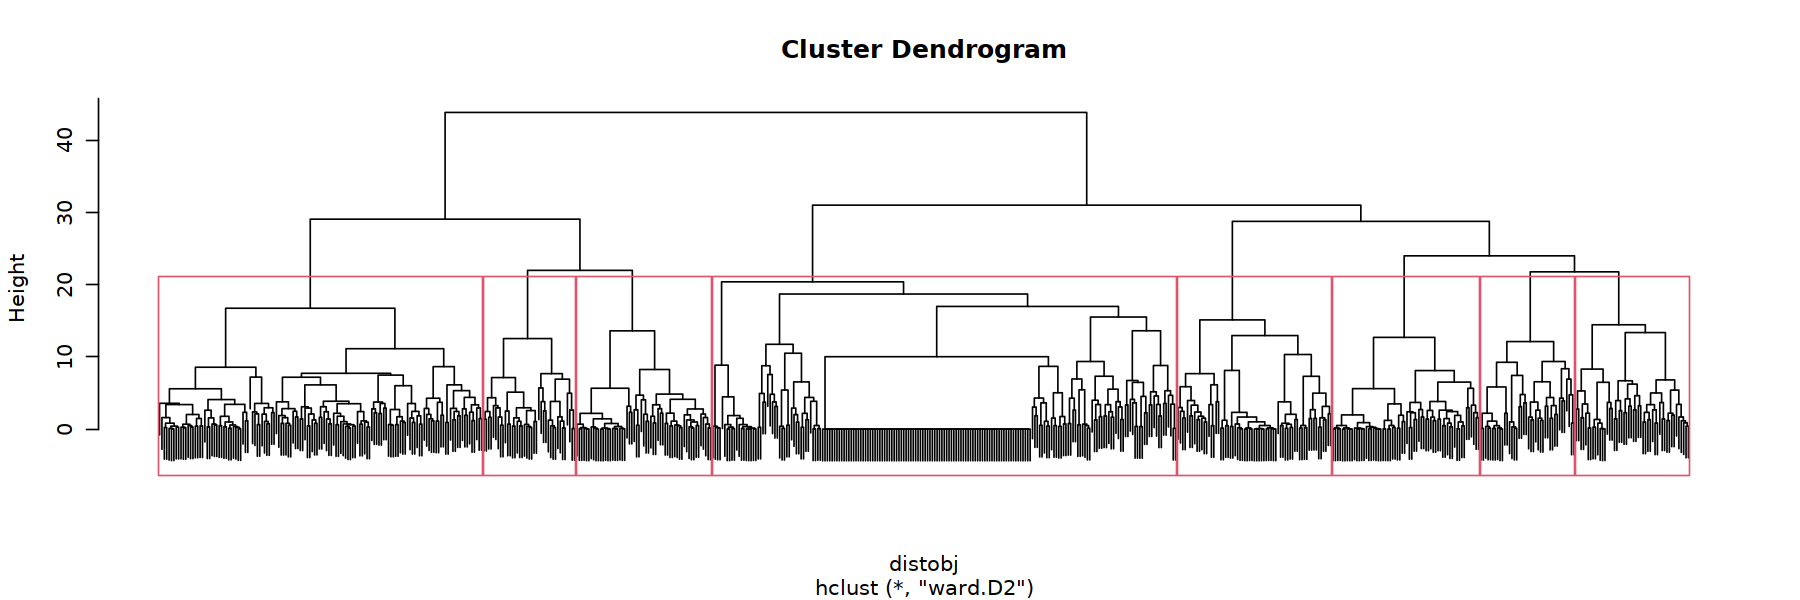

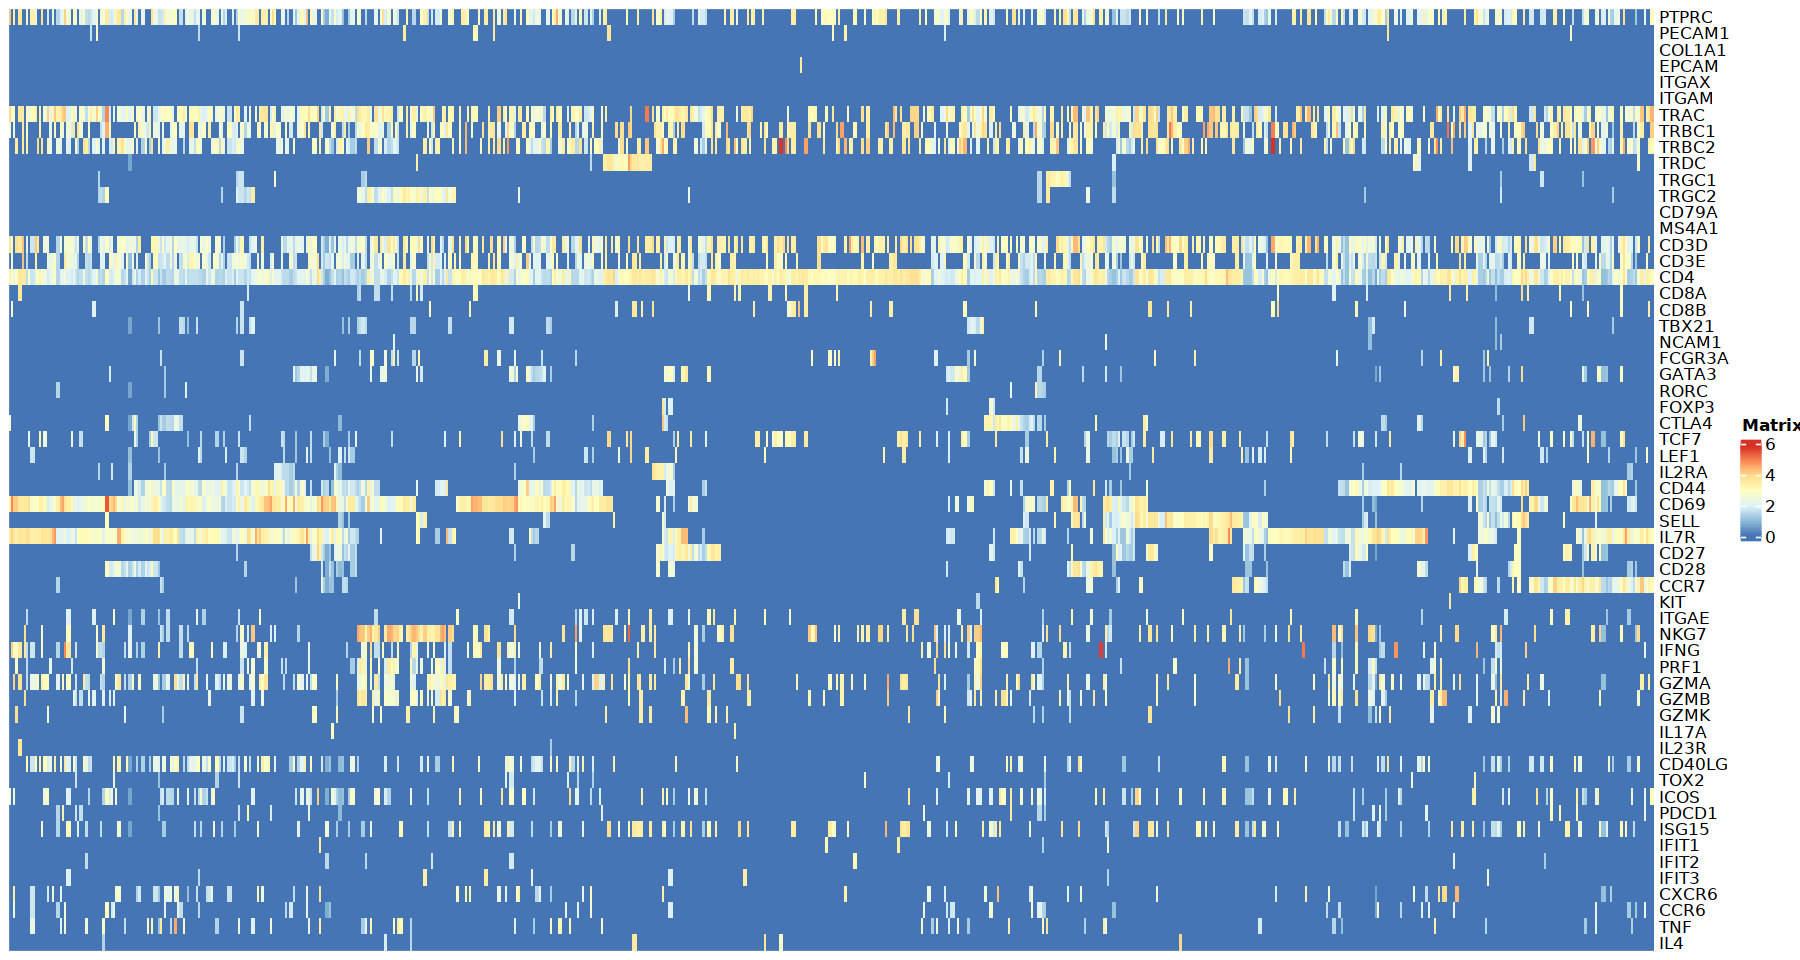

In [15]:
# 2.1 层次聚类
## 注意，mat是从Seurat来的feature-by-sample矩阵，应该转置成sample-by-feature矩阵；
## 此处选择一些基因做聚类，然后用另一些基因画zheng
distobj   <- dist(t(mat[c("IL2RA",'CD44','CD69',"SELL",'IL7R',"CD27","CD28","CCR7","TRDC","TRGC1","TRGC2",
                         "GATA3","RORC","FOXP3","CTLA4","TBX21") , ]), method = "euclidean")
hclustobj <- hclust(distobj, method = "ward.D2" )

# 2.2 切隔树形成聚类
sub_grp <- cutree(hclustobj, k = 8) #参数k直接指定类别数,也可用参数h指定切割深度
# 打印各类里的细胞数看看
table(sub_grp) 
# 打印聚类树看看
options(repr.plot.width=15, repr.plot.height=5)
plot(hclustobj, cex = 0.1, label=F) #画🌲，label=F隐藏样本名，不然过密不美观
rect.hclust(hclustobj, k = 8) #画方框
# 按聚类树顺序画heatmap看看
library(pheatmap)
options(repr.plot.width=15, repr.plot.height=8)
pheatmap(mat[,hclustobj$order], cluster_rows =F, cluster_cols = F, 
         border_color=NA,
         show_colnames = F, use_raster=TRUE)

# 看看要是还行，就把层次聚类的结果标签弄进metadata去
t.cd4@meta.data["CD4sub"]<-as.character(sub_grp)


In [20]:
meta = t.cd4@meta.data[ordered.cells,]


library(paletteer)  
cl_levels = unique(meta$subgroup)
blockcol = paletteer_d("ggsci::default_igv")[1:length(cl_levels)] %>% as.vector
names(blockcol) <-cl_levels


colann <- HeatmapAnnotation(
    cluster = meta$cluster,
    organ   = meta$organ,
    subgroup= meta$CD4sub,
    #col = list( subgroup = blockcol ),
    annotation_legend_param=list(
        cluster = list(nrow=5),
        organ = list(nrow=3),
        subgroup=list(nrow=1)
    )
)

In [21]:
hm<-Heatmap(mat, name = "Normalized expression", 
        cluster_rows = T, 
        cluster_columns = hclustobj, show_column_names=FALSE,
        column_dend_height = unit(4, "cm"),
        
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(0,1.5,3), c("#486E9E", "white", "#D84B59")),
        column_title_rot=90, column_gap=unit(2, "mm"),
        top_annotation=colann, heatmap_legend_param = list(direction = "horizontal"),
        use_raster = TRUE)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



In [23]:
options(warn=-1)
options(repr.plot.width=20, repr.plot.height=20)
cairo_pdf("CD4.hm.pdf",width=15, height = 18)
draw(hm,
     padding = unit(c(10, 10, 30, 3), "mm"), #上右下左
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

png 
  2

In [24]:
seu <- t.cd4
seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures=1000,verbose=F)
seu <- ScaleData(seu, features = rownames(seu), verbose=F, block.size=1000, min.cells.to.block=200)
seu <- RunPCA(seu, features = VariableFeatures(object = seu), npcs = 50,verbose=F)
seu <- RunUMAP(seu, dims = 1:50, verbose = F, n.neighbors = 20L, min.dist = 0.2)
seu -> t.cd4 

In [44]:
t.cd4 <- FindNeighbors(t.cd4, dims = 1:20)
t.cd4 <- FindClusters(t.cd4, resolution = 0.9)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 642
Number of edges: 30840

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6584
Number of communities: 6
Elapsed time: 0 seconds


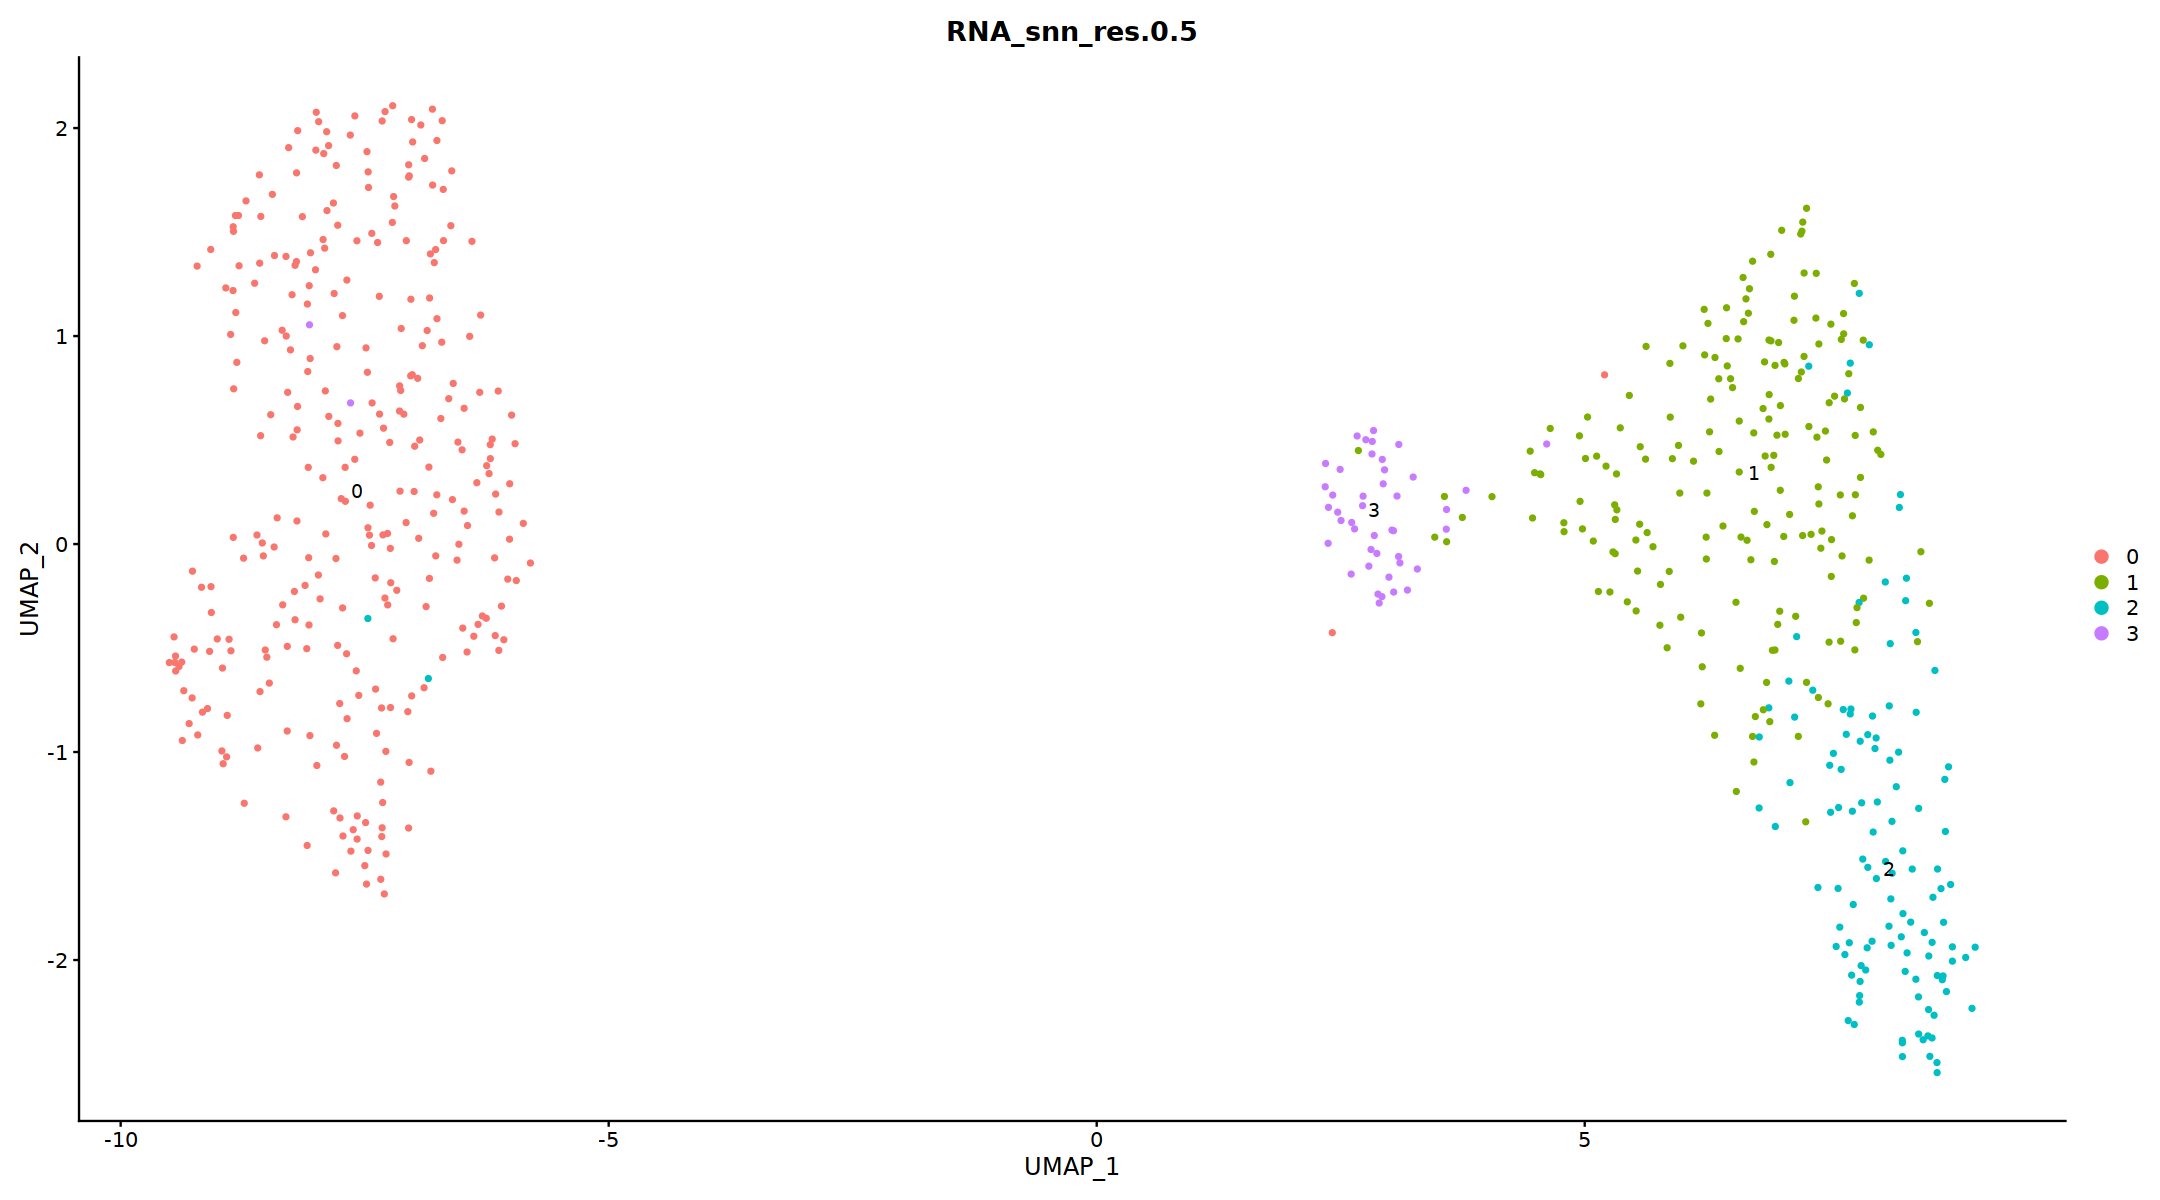

In [55]:
o(18,10)
DimPlot(t.cd4, group.by="RNA_snn_res.0.5", label=T)

In [56]:
Idents(t.cd4)<-"RNA_snn_res.0.5"
cd4.sub.markers<-FindAllMarkers(t.cd4, only.pos = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [57]:
cd4.sub.markers%>%filter(avg_log2FC>1 & p_val_adj<0.005) %>%
group_by(cluster)%>%top_n(wt = avg_log2FC, n=5)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.649786e-54,3.985754,0.549,0.009,1.601453e-49,0,RPL9P8
2.029726e-46,3.824495,0.478,0.003,8.906031e-42,0,GAS5
2.686898e-42,3.660422,0.447,0.006,1.178957e-37,0,SNHG5
5.213132e-27,3.196263,0.292,0.000,2.287418e-22,0,MT-TW
1.695852e-26,3.273406,0.298,0.006,7.441058e-22,0,MT-RNR1
5.559851e-54,2.133304,0.984,0.500,2.439551e-49,1,MALAT1
8.272889e-48,2.191185,0.952,0.452,3.629978e-43,1,CXCR4
7.375418e-41,2.037411,0.758,0.217,3.236186e-36,1,HSPA1B
1.309134e-33,1.901737,0.774,0.287,5.744218e-29,1,JUN


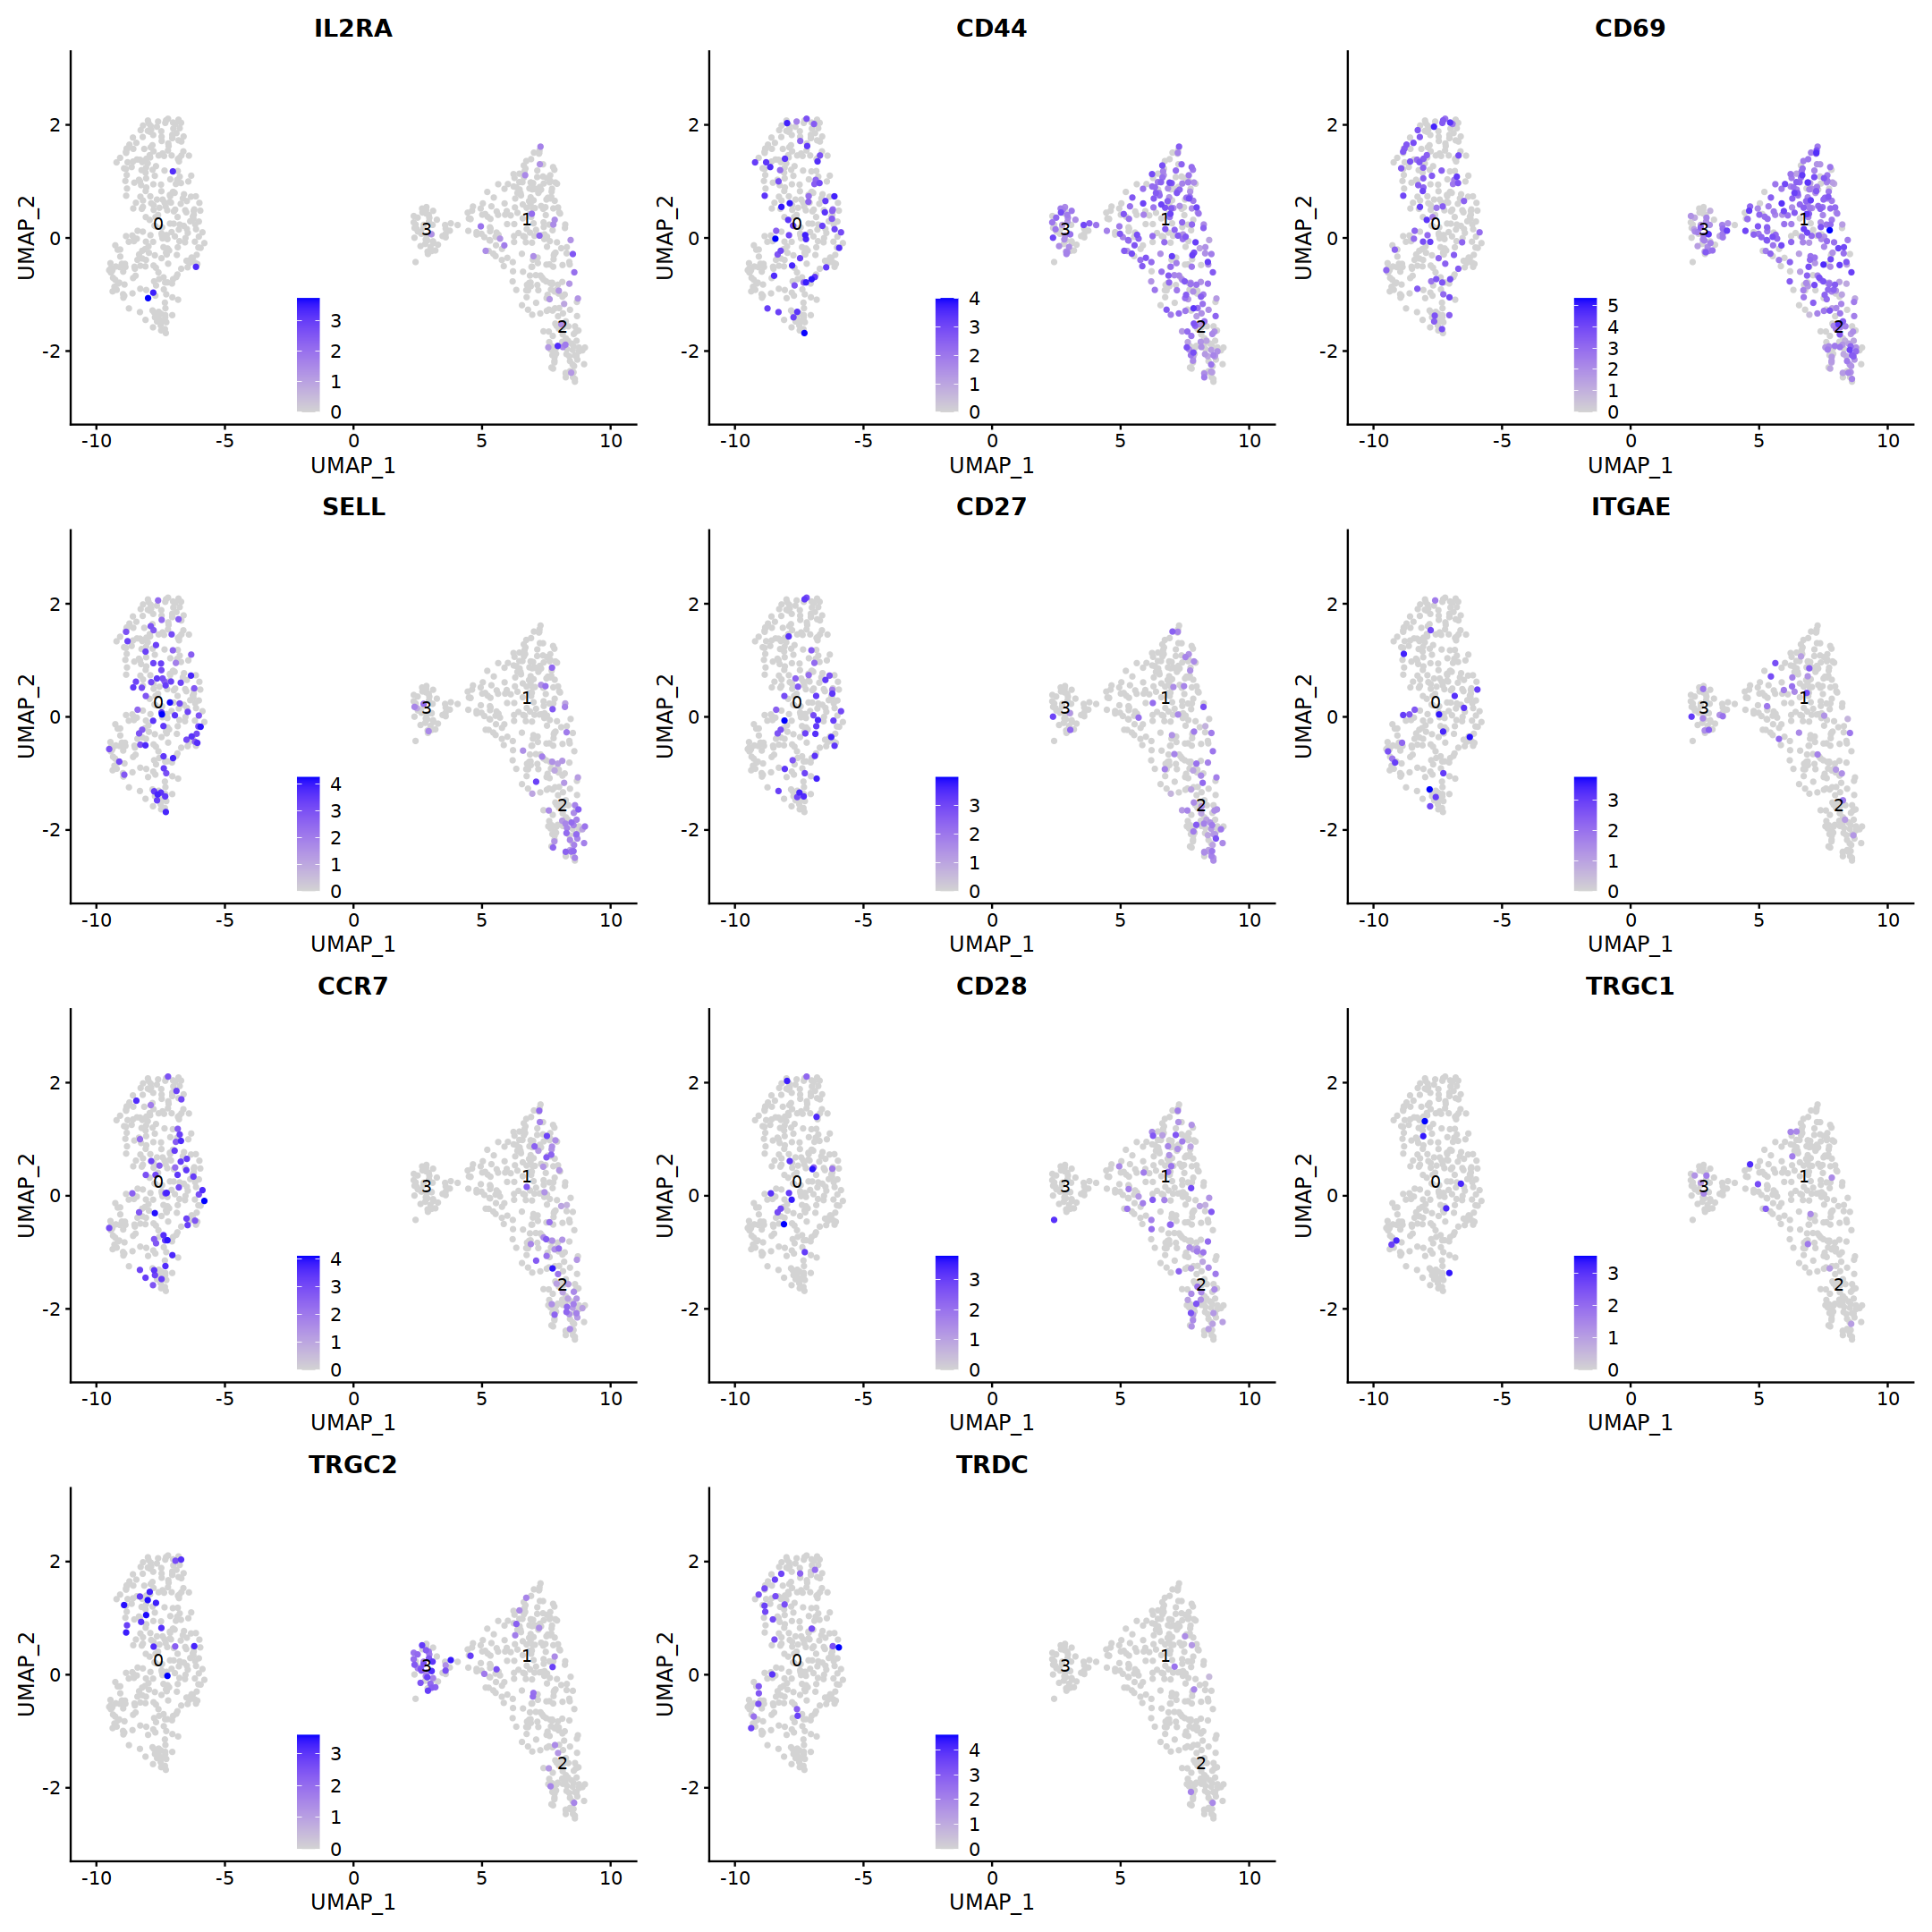

In [78]:
o(6*3, 6*3)
Idents(t.cd4)<-"RNA_snn_res.0.5"
FeaturePlot(t.cd4,order=T,n=3,  label=T,
            features = c("IL2RA","CD44","CD69","SELL","CD27","ITGAE","CCR7","CD28","TRGC1","TRGC2","TRDC")
           )&theme(legend.position = c(0.4,0.2))

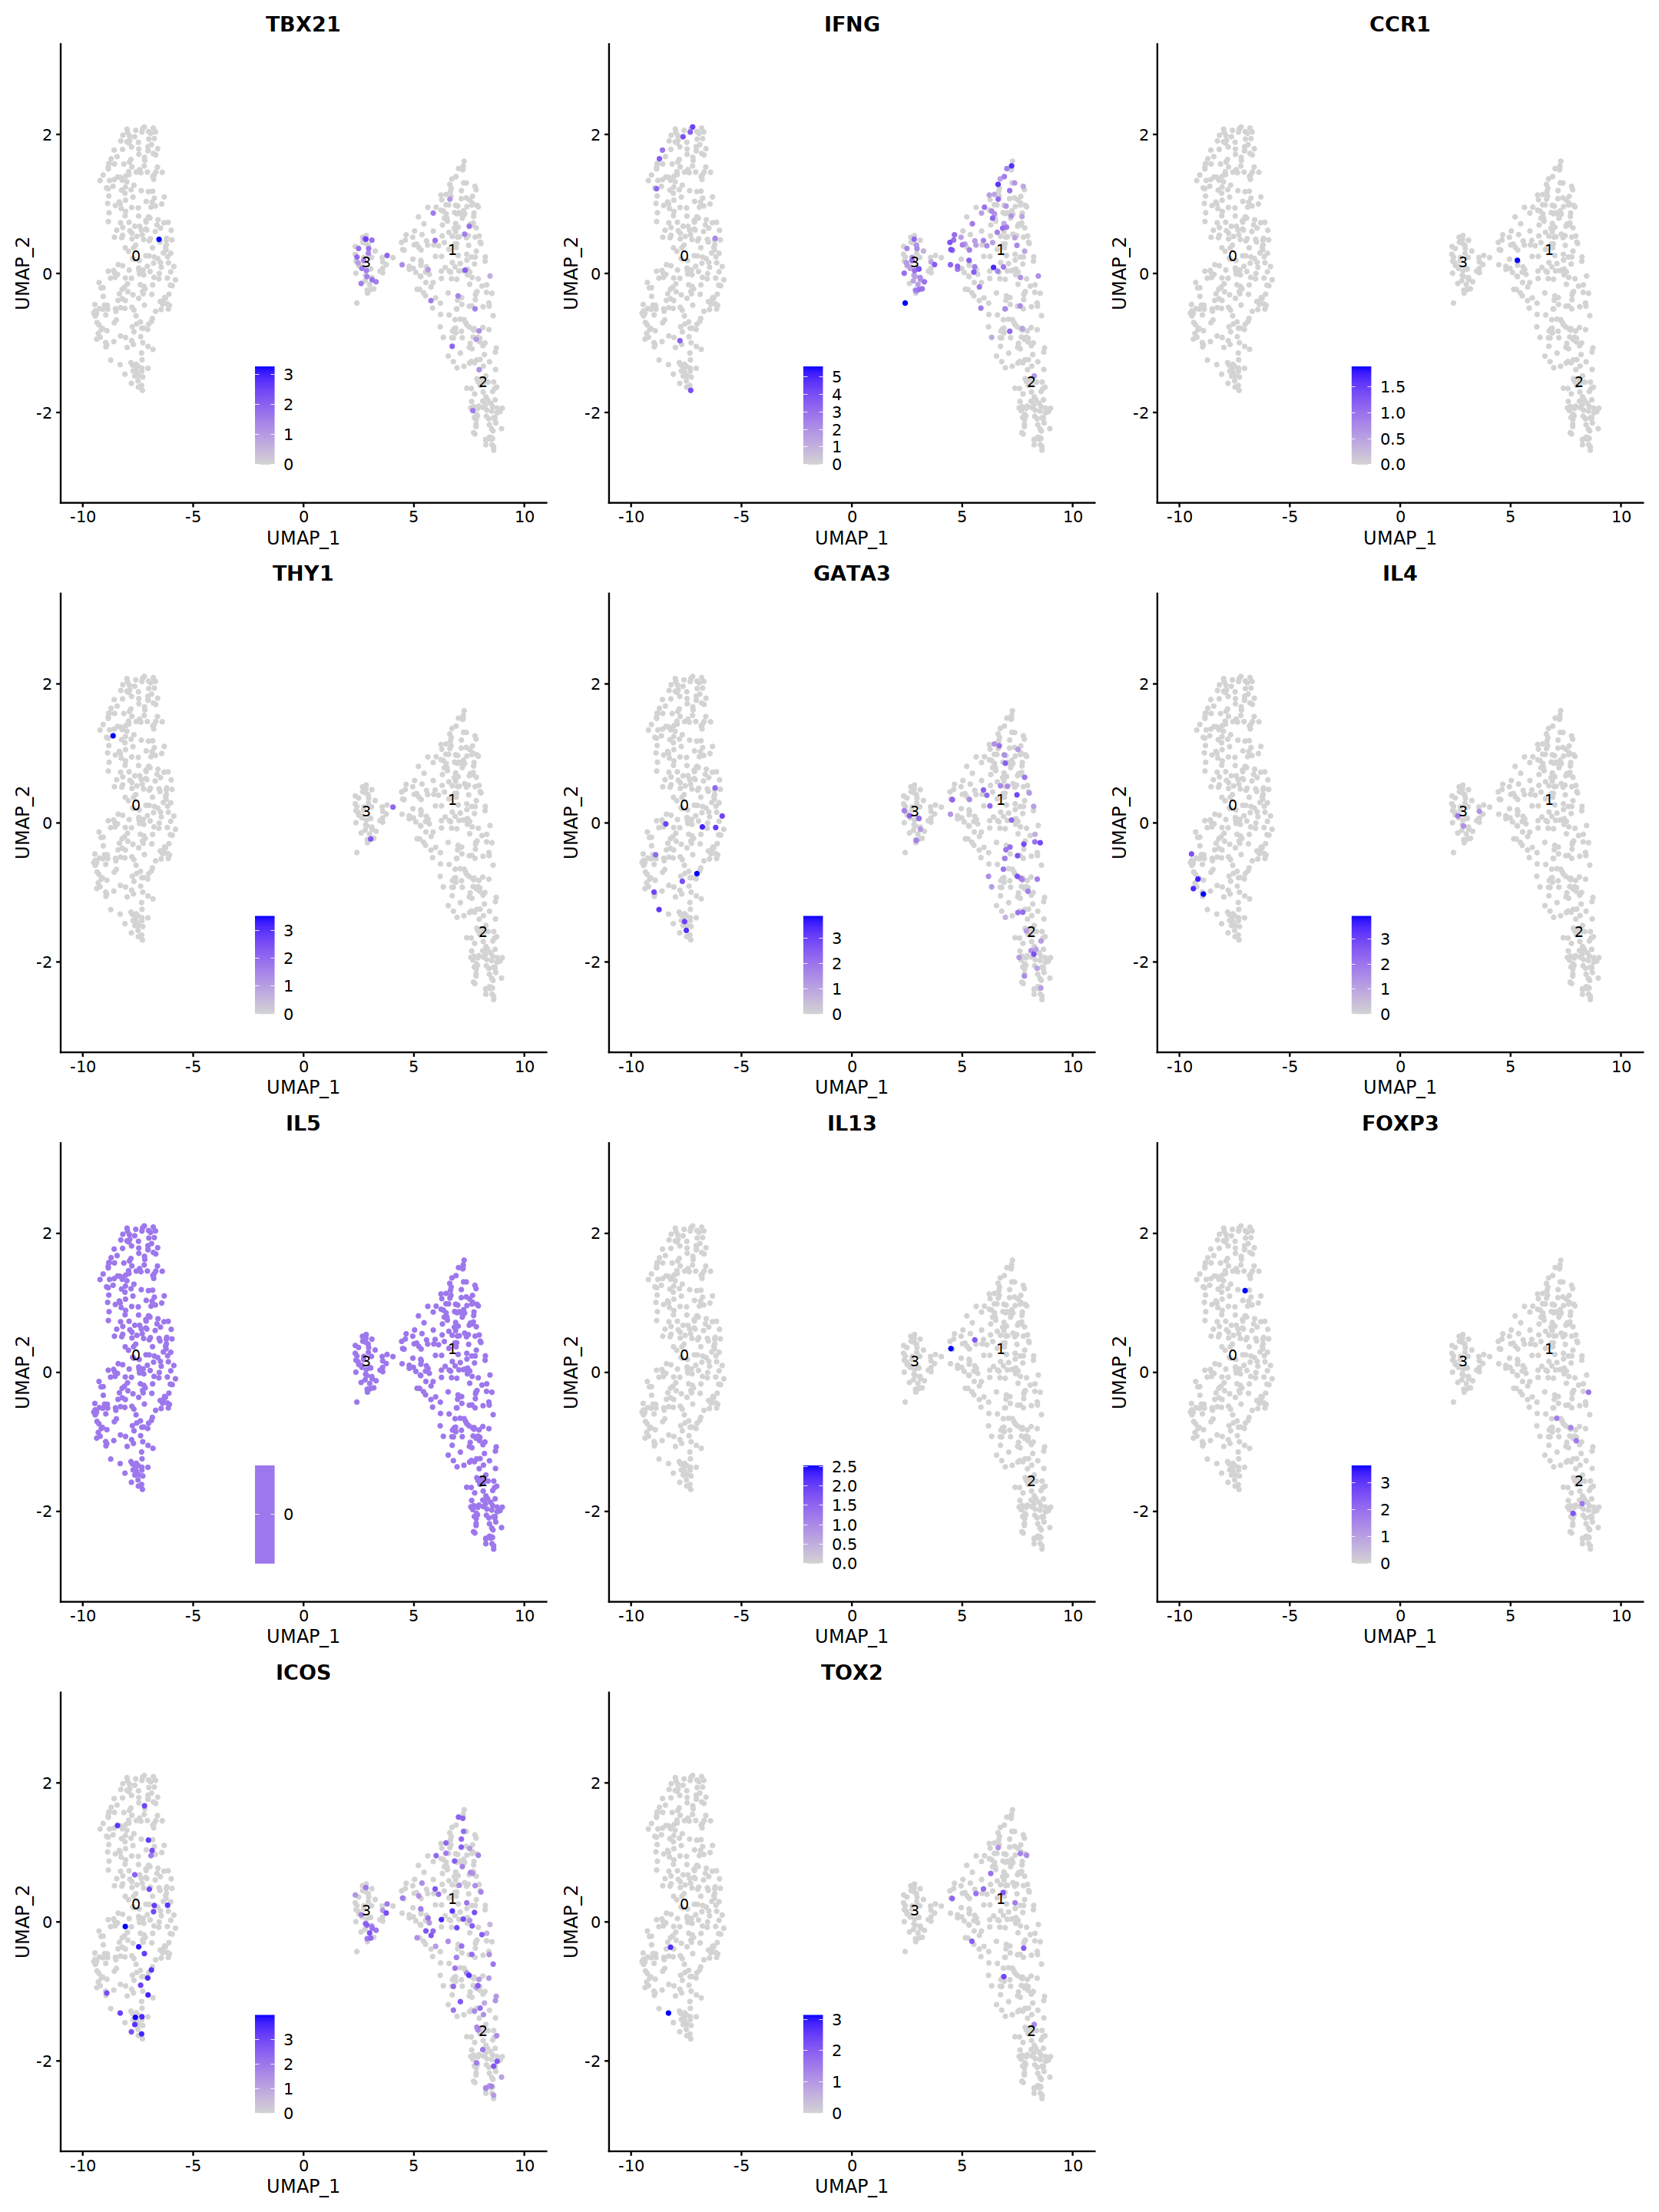

In [70]:
o(6*3, 6*4)
Idents(t.cd4)<-"RNA_snn_res.0.5"
FeaturePlot(t.cd4,order=T,n=3, label=T,
            features = c("TBX21","IFNG","CCR1","THY1","GATA3","IL4","IL5","IL13",
                         "FOXP3","ICOS","TOX2")
           )&theme(legend.position = c(0.4,0.2))

In [ ]:
t.cd4 <- RenameIdents(t.cd4, "0"="Tcm", "1"="Tem", "2"="Tcm", "3"="Th1")
Idents(t.cd4)->t.cd4[["CD4sub"]]

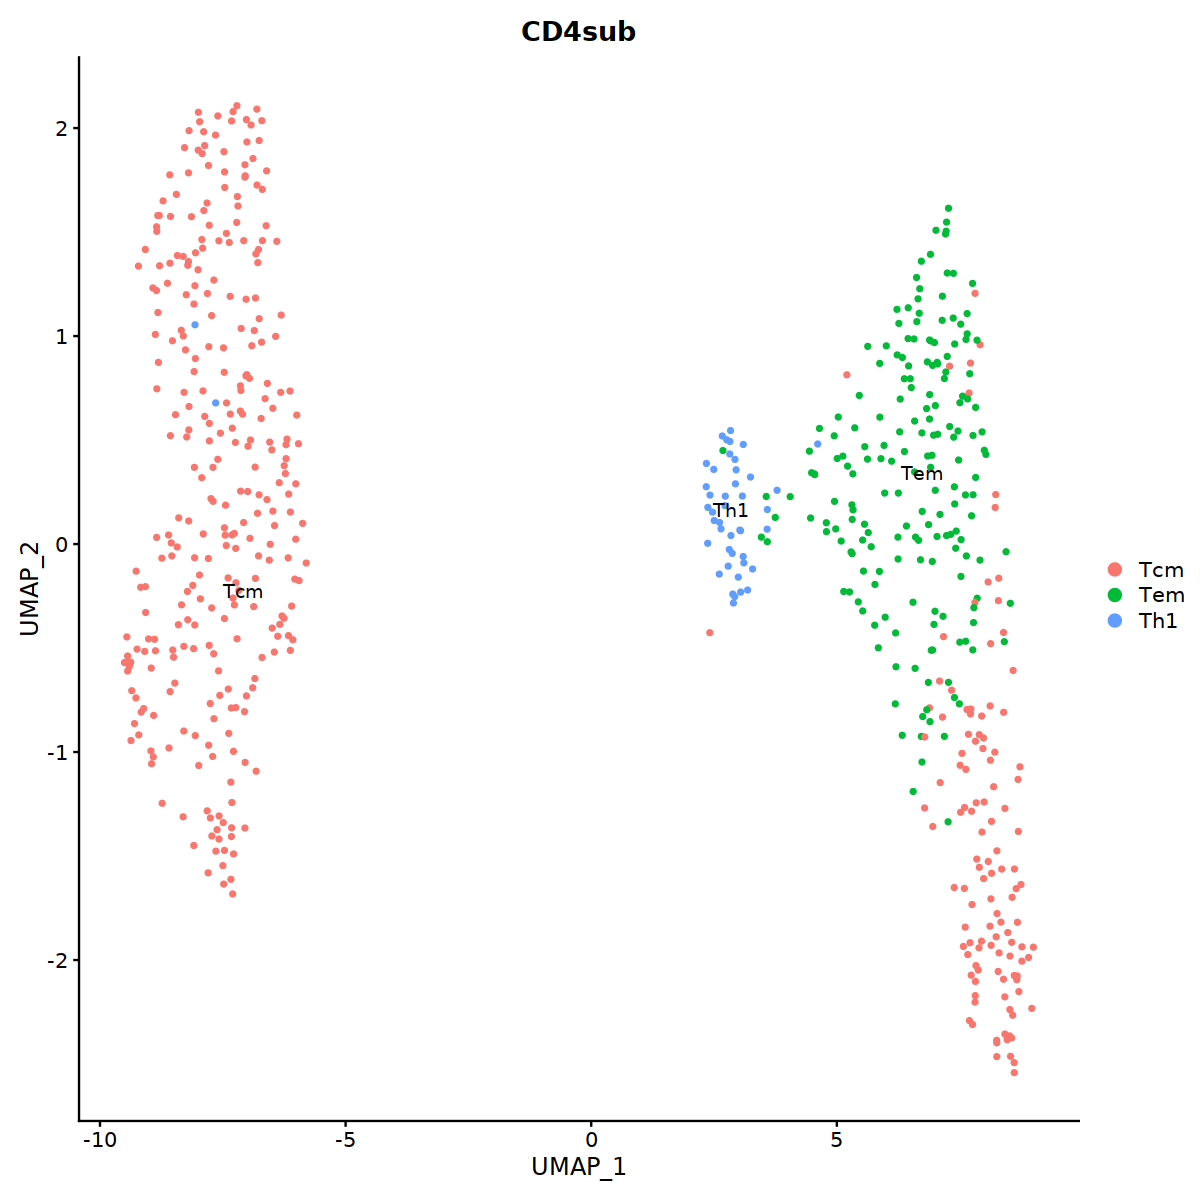

In [79]:
o(10,10)
DimPlot(t.cd4, label=T, group.by="CD4sub")

In [77]:
save(t.cd4, file = "t.cd4.annot.rda")